**Task:**
If you mastered the previous challenge, here is an additional one to keep it interesting. A web repository contains the following data set with a task: Can you detect which of these satellite images contains a cotton field and not one of the various types of soil?

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mat_file_path = '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/satimage-2.mat'
mat_contents = sio.loadmat(mat_file_path)

# convert into a pandas dataframe 
X = pd.DataFrame(mat_contents['X'])
y = pd.DataFrame(mat_contents['y'])

: 

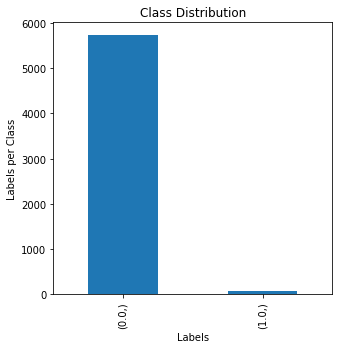

In [ ]:
import matplotlib.pyplot as plt

#%matplotlib inline
#plt.close('all')

plt.figure(figsize=(5,5))
y.value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Labels per Class')
plt.title('Class Distribution')
plt.show()

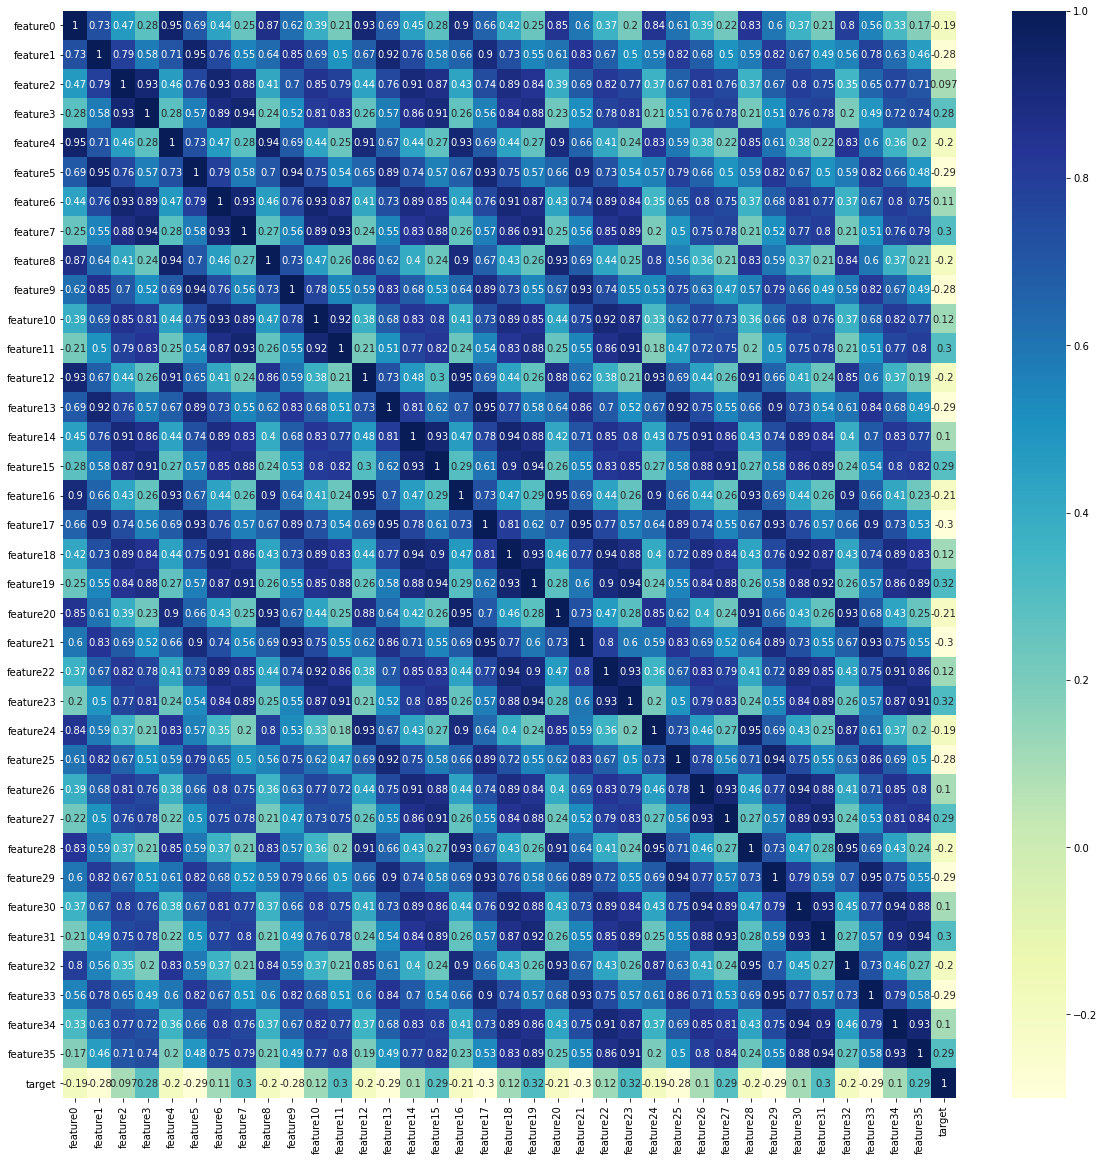

In [ ]:
import seaborn as sns

# create seaborn plot to lool at correlation

df = pd.concat([X, y], axis=1)

columnames = []
for i in range(0,36 ):
  columnames.append('feature' + str(i))
columnames.append('target')
df.columns = columnames

fig, ax = plt.subplots(figsize=(20,20))

ax = sns.heatmap(df.corr(),  ax=ax, cmap='YlGnBu', annot=True)

it looks like some of the features have a higher correlation with our target variabel than others 

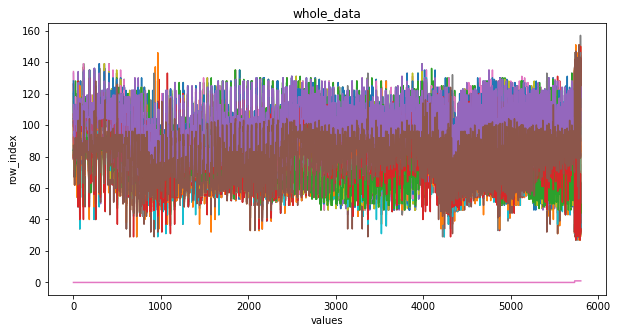

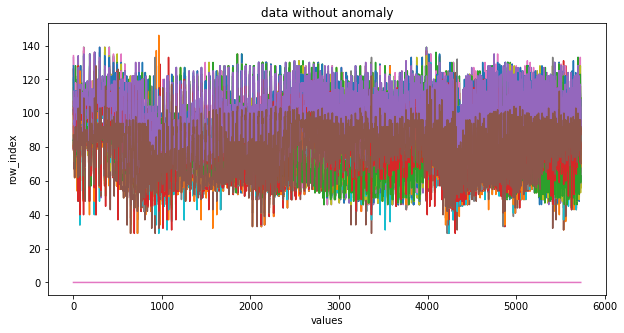

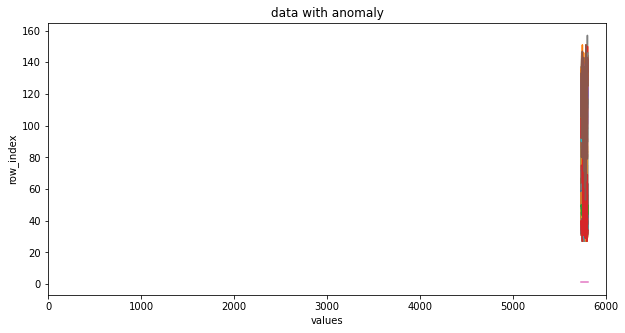

In [ ]:
# whole data 
plt.figure(figsize=(10,5))
plt.plot(df)
plt.xlabel('values')
plt.ylabel('row_index')
plt.title('whole_data')
plt.show()

# with out anomaly
plt.figure(figsize=(10,5))
plt.plot(df[df['target']==0])
plt.xlabel('values')
plt.ylabel('row_index')
plt.title('data without anomaly')
plt.show()

# with  anomaly
plt.figure(figsize=(10,5))
plt.plot(df[df['target']==1])
plt.xlabel('values')
plt.ylabel('row_index')
plt.title('data with anomaly')
plt.xlim([0,6000])
plt.show()


# load Sklearn modules

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [ ]:
# stolen from Patricia 
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

# Isolation Forest Approach

In [ ]:
# get train & test set
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42, stratify = df['target'])


In [ ]:
# feature scaling 
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

In [ ]:
# build isolation forest 
from sklearn.ensemble import IsolationForest
isof = IsolationForest(random_state=42)
isof = IsolationForest(n_estimators=100, max_features=0.7, contamination=2/6, random_state=42, max_samples="auto")
# predict 
y_train_pred = isof.fit_predict(X_train)
y_test_pred = isof.predict(X_test)

In [ ]:
# due to sklearn implementation
def map_values(x):
    if x == -1: # since outliers are labeld with -1
        return 1
    else:
        return 0


vectorize = np.vectorize(lambda x: map_values(x))

y_train_pred = vectorize(y_train_pred)
y_test_pred = vectorize(y_test_pred)

In [ ]:
# look at classification report 
from sklearn.metrics import classification_report
print('TRAINING:')
print(classification_report(y_train, y_train_pred))
print('TEST:')
print(classification_report(y_test, y_test_pred))

TRAINING:
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      4585
         1.0       0.04      1.00      0.07        57

    accuracy                           0.68      4642
   macro avg       0.52      0.84      0.44      4642
weighted avg       0.99      0.68      0.80      4642

TEST:
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79      1147
         1.0       0.03      1.00      0.06        14

    accuracy                           0.65      1161
   macro avg       0.52      0.82      0.43      1161
weighted avg       0.99      0.65      0.78      1161



              precision    recall  f1-score   support

      normal       1.00      0.65      0.79      1147
     anomaly       0.03      1.00      0.06        14

    accuracy                           0.65      1161
   macro avg       0.52      0.82      0.43      1161
weighted avg       0.99      0.65      0.78      1161

AUC:  82.4%


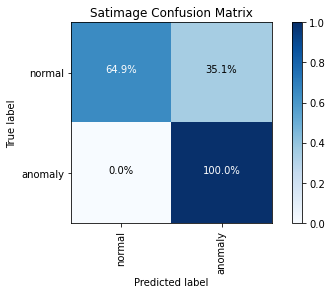

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=['normal', 'anomaly']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, title="Satimage Confusion Matrix", save=True, saveas="IF_SA_Test.png", classes=['normal', 'anomaly'])

# Isolation Forest HP Tuning

In [ ]:
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1, average = 'binary'), 'Precision': make_scorer(precision_score, pos_label=-1, average = 'binary')}

In [ ]:
# needed because of the results from isolation forest
y_train_trans = y_train.copy()
y_train_trans[y_train_trans == 1]  = -1
y_train_trans[y_train_trans == 0] = 1
gs = GridSearchCV(IsolationForest(random_state=42, n_jobs=-1),
                  param_grid={'n_estimators': [50,150,200],
                            'max_samples': ['auto',50,100],
                            'contamination': ['auto', 0.15, 0.3],
                              },
                  scoring=scoring, refit='Recall', verbose =1)
gs.fit(X_train_minmax, y_train_trans)
print(gs.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.7min finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=50, n_estimators=50, n_jobs=-1,
                random_state=42, verbose=0, warm_start=False)


              precision    recall  f1-score   support

      normal       1.00      0.68      0.81      1147
     anomaly       0.04      1.00      0.07        14

    accuracy                           0.69      1161
   macro avg       0.52      0.84      0.44      1161
weighted avg       0.99      0.69      0.80      1161

AUC:  84.1%


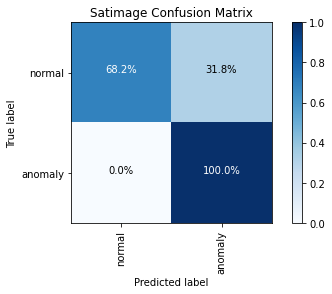

In [ ]:
y_train_pred = gs.best_estimator_.fit_predict(X_train_minmax)
y_test_pred = gs.best_estimator_.predict(X_test_minmax)

y_train_pred = vectorize(y_train_pred)
y_test_pred = vectorize(y_test_pred)

print(classification_report(y_test, y_test_pred, target_names=['normal', 'anomaly']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, title="Satimage Confusion Matrix", save=True, saveas="IF_SA_Test.png", classes=['normal', 'anomaly'])

# PCA as help for ISOF 

The goal is to improve the isolation forest with an initial principal component analysis

In [ ]:
from sklearn.decomposition import PCA

# create PCA 

pca = PCA(n_components=3) 

X_train_reduced = pca.fit_transform(X_train_minmax)
X_test_reduced = pca.transform(X_test_minmax)

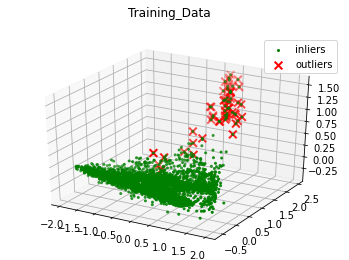

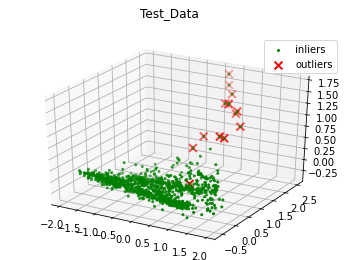

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

y_train_index = y_train.copy()
y_train_index.reset_index(inplace=True, drop=True)
outlier_index = y_train_index[y_train_index == 1].index

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the compressed data points
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], zs=X_train_reduced[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_train_reduced[outlier_index,0],X_train_reduced[outlier_index,1], X_train_reduced[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
fig.suptitle('Training_Data')
plt.show()

y_test_index = y_test.copy()
y_test_index.reset_index(inplace=True, drop=True)
outlier_index = y_test_index[y_test_index == 1].index

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the compressed data points
ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], zs=X_test_reduced[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_test_reduced[outlier_index,0],X_test_reduced[outlier_index,1], X_test_reduced[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
fig.suptitle('Test_Data')
plt.show()

let's try to understand our components

In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_train.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print('Those are the most important features:' , most_important_names)


Those are the most important features: ['feature17', 'feature12', 'feature9']


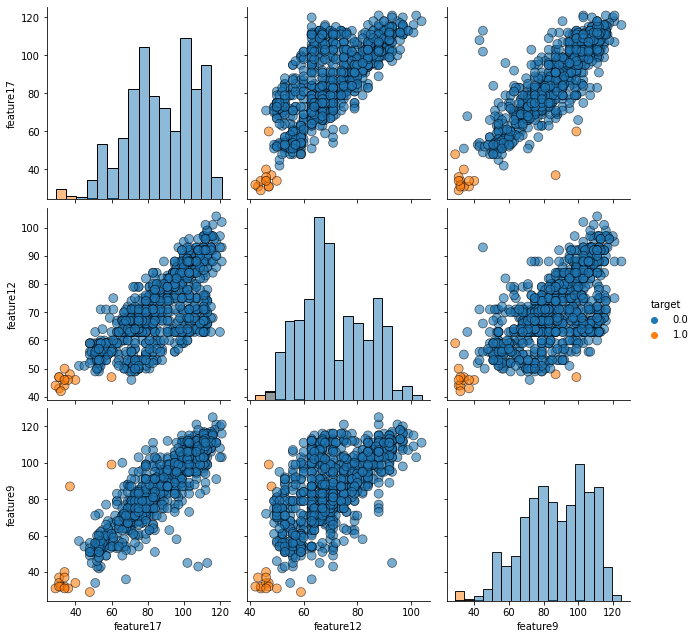

In [ ]:
 sns.pairplot(df.sample(1000), hue='target', height=3, diag_kind='hist', vars = most_important_names, plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'})

Could we have seen that from the beginning? 
The features where the ones with the highest correlation... 

In [ ]:
# Make ISOF with PCA
pca = PCA(n_components=3) 

X_train_reduced = pca.fit_transform(X_train_minmax)
X_test_reduced = pca.transform(X_test_minmax)

In [ ]:
X_train_reduced = pca.fit_transform(X_train_minmax)
X_test_reduced = pca.transform(X_test_minmax)

In [ ]:
# needed because of the results from isolation forest
y_train_trans = y_train.copy()
y_train_trans[y_train_trans == 1]  = -1
y_train_trans[y_train_trans == 0] = 1

# gridsearch
gs = GridSearchCV(IsolationForest( random_state=42, n_jobs=-1),
                  param_grid={'n_estimators': [50,150,200],
                            'max_samples': ['auto',50,100],
                            'contamination': ['auto', 0.15, 0.3]
                              },
                  scoring=scoring, refit='Recall', verbose =1)
gs.fit(X_train_reduced, y_train_trans)
print(gs.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=50,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.1min finished


              precision    recall  f1-score   support

      normal       1.00      0.78      0.88      1147
     anomaly       0.05      0.93      0.09        14

    accuracy                           0.79      1161
   macro avg       0.52      0.86      0.49      1161
weighted avg       0.99      0.79      0.87      1161

AUC:  85.7%


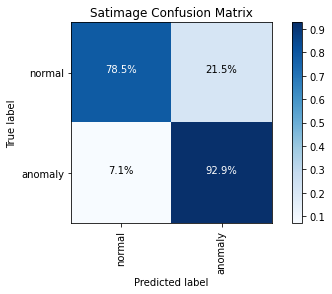

In [ ]:
y_train_pred = gs.best_estimator_.fit_predict(X_train_reduced)
y_test_pred = gs.best_estimator_.predict(X_test_reduced)

y_train_pred = vectorize(y_train_pred)
y_test_pred = vectorize(y_test_pred)

print(classification_report(y_test, y_test_pred, target_names=['normal', 'anomaly']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, title="Satimage Confusion Matrix", save=True, saveas="IF_SA_Test.png", classes=['normal', 'anomaly'])

PCA with 9 instead of 3 components

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.2min finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=50,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

      normal       1.00      0.91      0.95      1147
     anomaly       0.12      1.00      0.21        14

    accuracy                           0.91      1161
   macro avg       0.56      0.95      0.58      1161
weighted avg       0.99      0.91      0.94      1161

AUC:  95.4%


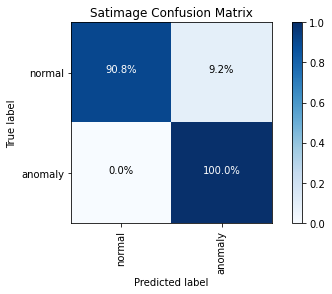

In [ ]:
# pca with 9 components: 
pca = PCA(n_components=9) 

X_train_reduced = pca.fit_transform(X_train_minmax)
X_test_reduced = pca.transform(X_test_minmax)

# needed because of the results from isolation forest
y_train_trans = y_train.copy()
y_train_trans[y_train_trans == 1]  = -1
y_train_trans[y_train_trans == 0] = 1
gs = GridSearchCV(IsolationForest( random_state=42, n_jobs=-1),
                  param_grid={'n_estimators': [50,150,200],
                            'max_samples': ['auto',50,100],
                            'contamination': ['auto', 0.15, 0.3],
                              },
                  scoring=scoring, refit='Recall', verbose =1)
gs.fit(X_train_reduced, y_train_trans)
print(gs.best_estimator_)

y_train_pred = gs.best_estimator_.fit_predict(X_train_reduced)
y_test_pred = gs.best_estimator_.predict(X_test_reduced)

y_train_pred = vectorize(y_train_pred)
y_test_pred = vectorize(y_test_pred)

print(classification_report(y_test, y_test_pred, target_names=['normal', 'anomaly']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, title="Satimage Confusion Matrix", save=True, saveas="IF_SA_Test.png", classes=['normal', 'anomaly'])

precision looks much better here 

# PCA Approach with Gausian

In [ ]:
from sklearn.decomposition import PCA

# create PCA 

pca = PCA(n_components=2) 

X_train_reduced = pca.fit_transform(X_train_minmax)
X_test_reduced = pca.transform(X_test_minmax)

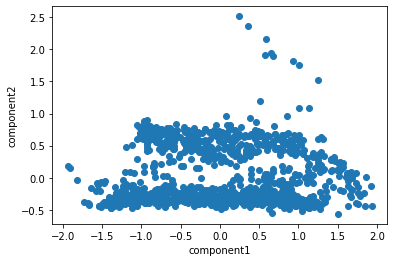

In [ ]:
plt.figure()
plt.xlabel("component1")
plt.ylabel("component2")
plt.plot(X_test_reduced[:,0], X_test_reduced[:,1],"o")
plt.show()

In [ ]:
from scipy.stats import multivariate_normal

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

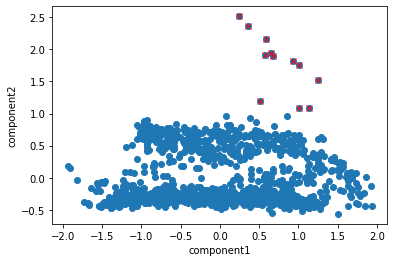

In [ ]:
# distance is estimate Gaussian based on live coding 
mu, sigma = estimateGaussian(X_test_reduced)
p = multivariateGaussian(X_test_reduced,mu,sigma)

# Hand code epsilon
ep = 0.015

outliers = np.asarray(np.where(p < ep))



plt.figure()
plt.xlabel("component1")
plt.ylabel("component2")
plt.plot(X_test_reduced[:,0], X_test_reduced[:,1],"o")
plt.plot(X_test_reduced[outliers,0],X_test_reduced[outliers,1],"rx")
plt.show()

In [ ]:
# create y pred based on outliers
y_test_pred = np.zeros(len(y_test))
y_test_pred[outliers] = 1

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1147
     anomaly       1.00      0.86      0.92        14

    accuracy                           1.00      1161
   macro avg       1.00      0.93      0.96      1161
weighted avg       1.00      1.00      1.00      1161

AUC:  92.9%


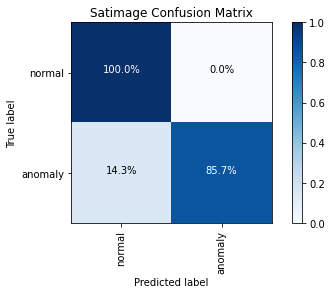

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=['normal', 'anomaly']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, title="Satimage Confusion Matrix", save=True, saveas="IF_SA_Test.png", classes=['normal', 'anomaly'])

also not a bad result